In [16]:
!pip install pandas numpy scikit-learn matplotlib seaborn




[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
!python -m pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/29/a2/d40fb2460e883eca5199c62cfc2463fd261f760556ae6290f88488c362c0/pip-25.1.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.8 MB 812.7 kB/s eta 0:00:03
   ------ --------------------------------- 0.3/1.8 MB 2.6 MB/s eta 0:00:01
   ---------------------------------- ----- 1.6/1.8 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
from sklearn.preprocessing import MultiLabelBinarizer
import ast


In [21]:
df = pd.read_csv("data/tmdb_5000_movies.csv")

# Convert budget and revenue
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Filter valid rows
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

# Define target
df['success'] = df['revenue'] > df['budget']


In [22]:
# Parse genres
df['genres'] = df['genres'].apply(lambda x: [g['name'] for g in ast.literal_eval(x)] if pd.notnull(x) else [])

# Keep top 10 genres
top_genres = df['genres'].explode().value_counts().head(10).index.tolist()
df['genres_filtered'] = df['genres'].apply(lambda g: [genre for genre in g if genre in top_genres])

# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genres_filtered']), columns=mlb.classes_)
df = pd.concat([df.reset_index(drop=True), genre_dummies], axis=1)


In [23]:
features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count'] + top_genres
df = df.dropna(subset=features)

X = df[features]
y = df['success']

# Save feature names for later
expected_features = X.columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.64      0.46      0.54       157
        True       0.84      0.92      0.88       489

    accuracy                           0.81       646
   macro avg       0.74      0.69      0.71       646
weighted avg       0.79      0.81      0.80       646



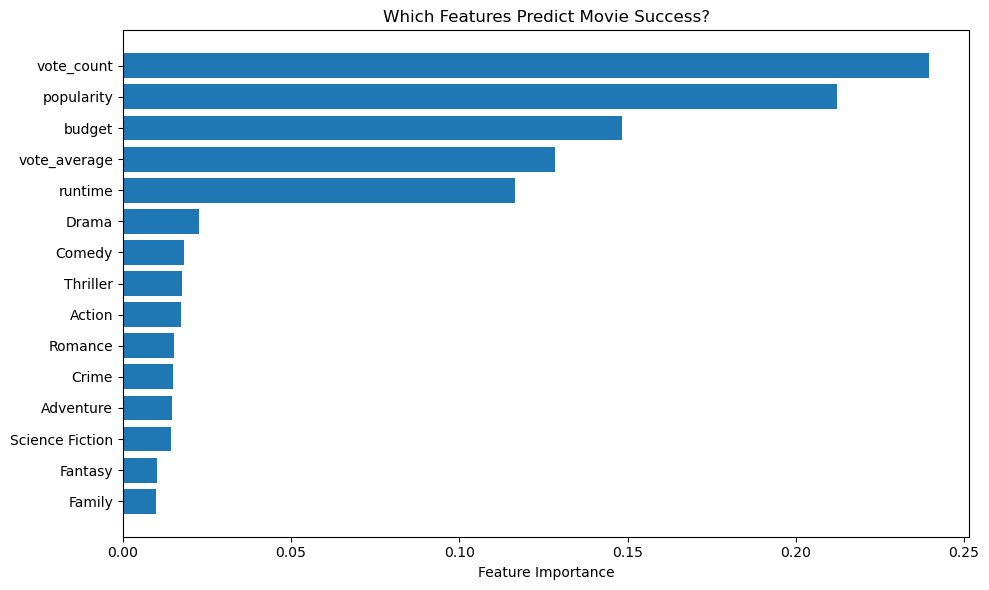

In [24]:
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importances)
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Which Features Predict Movie Success?")
plt.tight_layout()
plt.show()


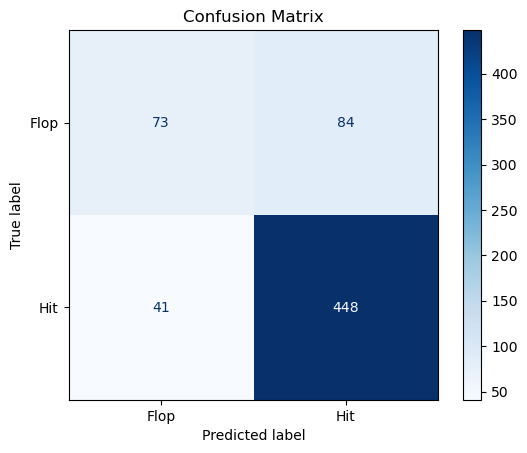

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flop', 'Hit'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


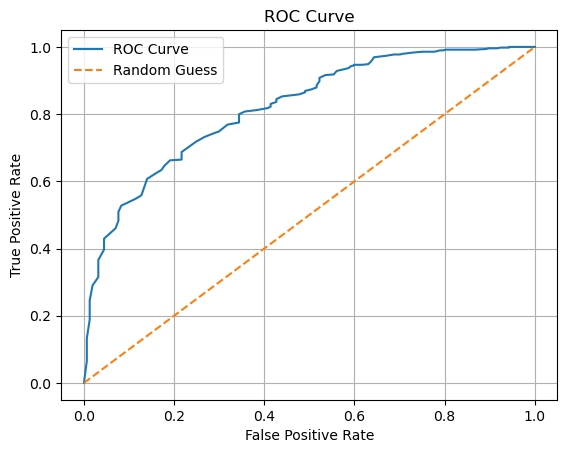

AUC Score: 0.819799929662772


In [26]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_proba))


In [27]:
# Prepare a blank input
my_input = {feature: 0 for feature in expected_features}

# Custom movie details
my_input.update({
    'budget': 80000000,
    'popularity': 40,
    'runtime': 120,
    'vote_average': 7.2,
    'vote_count': 3000,
    'Action': 1,
    'Drama': 1,
    'Thriller': 1
})

# Predict
my_movie = pd.DataFrame([my_input])
prediction = model.predict(my_movie)[0]
print("✅ HIT!" if prediction else "❌ FLOP!")


✅ HIT!
